In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src')

import pandas as pd
pd.set_option('display.max_rows', 100)

import cudf
import xgboost
import lightgbm
from pathlib import Path
from sklearn.metrics import mean_squared_error

from sales_project.plotters import linear_plot
from sales_project.evaluations import evaluate
from sales_project.utils import save_model, load_model
from sales_project.utils import save_predictions, read_yaml, save_yaml
from sales_project.tuners import run_optuna, time_series_objective

In [2]:
target = 'item_cnt_month'
timestamp_col = 'date_block_num'
min_timestamp = 8

df = pd.read_parquet("../data/artifacts/df3.parquet").query(f"{timestamp_col} >= {min_timestamp}")
df_submission = pd.read_parquet("../data/artifacts/df_submission.parquet")


features = list(df.columns)
features.remove(target)
features.remove(timestamp_col)
features.remove('shop_id')
features.remove('item_id')

df[target] = df[target].clip(0, 20)

df_test = df.query('date_block_num == 33')
df = df.query('date_block_num <= 32')

# XGBoost -> 0.95259

In [3]:
hyperparameters_grid = read_yaml(Path('../params/hyperparameter_grid/xgboost.yaml'))

run_optuna(
    df_train=df,
    df_test=df_test,
    df_submission=df_submission,
    features=features,
    target=target,
    objective=time_series_objective,
    scorer=lambda y, pred: mean_squared_error(y, pred)**(0.5),
    cv=1,
    val_ratio=0.1,
    direction="minimize",
    n_trials=1000,
    model_class = xgboost.XGBRegressor,
    hyperparameters_grid=hyperparameters_grid,
    is_gpu_accelerated=False
)

[I 2024-08-15 15:16:47,951] A new study created in memory with name: no-name-77ae821f-33ad-493b-a3d2-b9d292b10f00
[I 2024-08-15 15:18:42,589] Trial 0 finished with value: 0.9782158550442259 and parameters: {'max_leaves': 355, 'max_depth': 9, 'max_bin': 145, 'learning_rate': 5.5209463271920086e-05, 'subsample': 0.7311510475257026, 'colsample_bytree': 0.7185027486106269, 'colsample_bylevel': 0.5732472172259472, 'colsample_bynode': 0.4931314987114338, 'sampling_method': 'uniform', 'tree_method': 'hist', 'objective': 'reg:squarederror', 'device': 'cpu', 'n_jobs': 16, 'random_state': 42, 'verbosity': 0}. Best is trial 0 with value: 0.9782158550442259.
[I 2024-08-15 15:20:40,437] Trial 1 finished with value: 0.8912200947328074 and parameters: {'max_leaves': 352, 'max_depth': 9, 'max_bin': 157, 'learning_rate': 0.0024377371333921486, 'subsample': 0.7182552326285296, 'colsample_bytree': 0.8058972383752219, 'colsample_bylevel': 0.7503553292675547, 'colsample_bynode': 0.5166514039723205, 'sampli

: 

In [11]:
best_params = read_yaml(Path("../params/best/XGBRegressor_2024-08-15_16:44:26.yaml"))
model = xgboost.XGBRegressor(**best_params)
model.fit(df[features], df[target])
save_model(model, f"test_XGBRegressor_2024-08-15_16:44:26.pkl")

df_test['pred'] = model.predict(df_test[features]).clip(0, 20)
metrics = evaluate(df_test, target, 'pred')
print(metrics)

save_yaml('../params/best/testeval_XGBRegressor_2024-08-15_16:44:26.yaml', metrics)

{'MAE': 0.28403371572494507, 'MSE': 0.5653080344200134, 'RMSE': 0.7518696924467786, 'R2': 0.4289786219596863, 'MAPE': 596719402221568.0, 'SMAPE': nan}
yaml file saved at: ../params/best/testeval_XGBRegressor_2024-08-15_16:44:26.yaml


In [3]:
best_params = read_yaml(Path("../params/best/XGBRegressor_2024-08-15_16:44:26.yaml"))
model = xgboost.XGBRegressor(**best_params)
model.fit(
    pd.concat([df[features], df_test[features]]), 
    pd.concat([df[target], df_test[target]])
)
save_model(model, 'XGBRegressor_2024-08-15_16:44:26.pkl')

pkl file saved at: ../models/XGBRegressor_2024-08-15_16:44:26.pkl


In [4]:
df_submission[target] = model.predict(df_submission[features]).clip(0, 20)
save_predictions(df_submission[['shop_id', 'item_id', 'item_cnt_month']], 'XGBRegressor_2024-08-15_16:44:26.csv')

csv file saved at: ../data/predictions/XGBRegressor_2024-08-15_16:44:26.csv


# LightGBM -> 0.94863

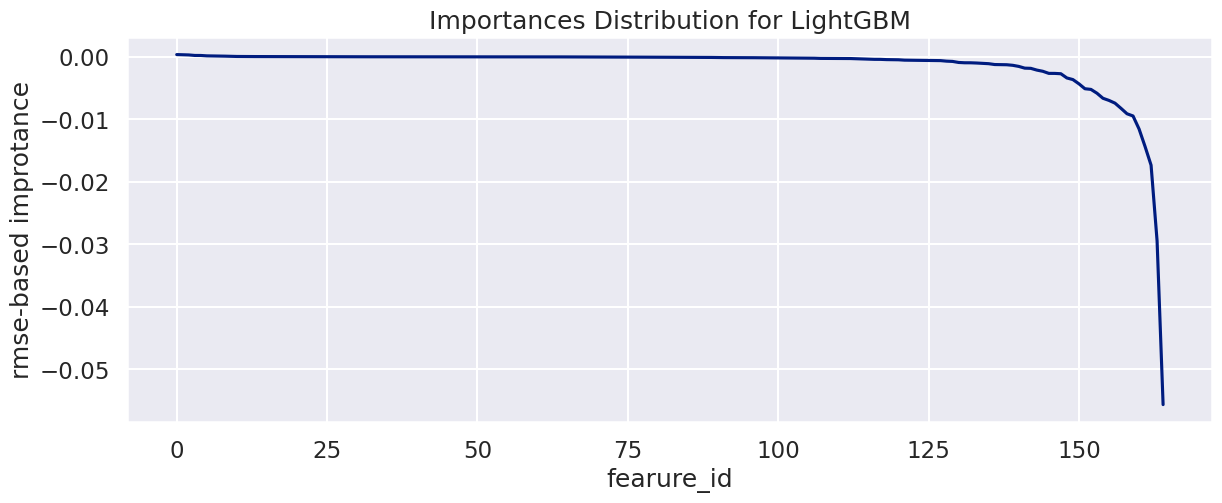

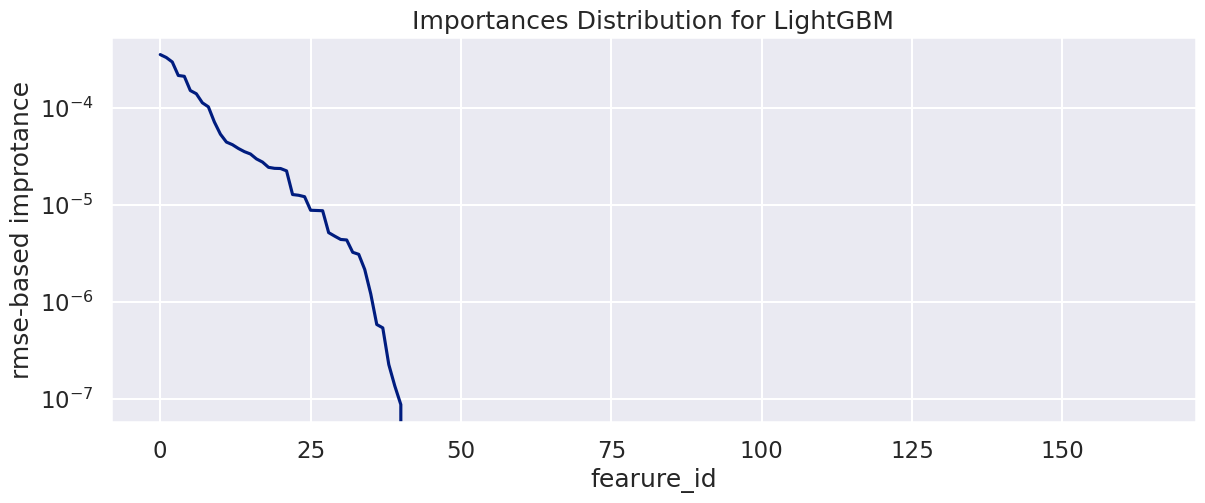

In [2]:
importances = pd.read_csv('../data/importances/lightgbm.csv')
importances_rmse = importances.groupby(['feature']).mean()[['RMSE']].sort_values(by='RMSE', ascending=False).reset_index()
importances_rmse['fearure_id'] = list(range(len(importances_rmse)))
linear_plot(
    data=importances_rmse, 
    x='fearure_id', 
    y='RMSE', 
    title='Importances Distribution for LightGBM',
    y_label='rmse-based improtance'
)
linear_plot(
    data=importances_rmse, 
    x='fearure_id', 
    y='RMSE', 
    title='Importances Distribution for LightGBM',
    y_label='rmse-based improtance',
    y_scale='log'
)

## All features -> 0.94863

In [4]:
hyperparameters_grid = read_yaml(Path('../params/hyperparameter_grid/lightgbm.yaml'))

run_optuna(
    df_train=df,
    df_test=df_test,
    df_submission=df_submission,
    features=features,
    target=target,
    objective=time_series_objective,
    scorer=lambda y, pred: mean_squared_error(y, pred)**(0.5),
    cv=1,
    val_ratio=0.1,
    direction="minimize",
    n_trials=1000,
    model_class = lightgbm.LGBMRegressor,
    hyperparameters_grid=hyperparameters_grid,
    is_gpu_accelerated=False
)

[I 2024-08-15 07:55:57,246] A new study created in memory with name: no-name-3091a011-953c-4d27-8b3c-75d169f5b6a8
[I 2024-08-15 07:59:38,705] Trial 0 finished with value: 0.6740214982070638 and parameters: {'n_estimators': 252, 'num_leaves': 387, 'learning_rate': 0.04064693141616252, 'max_bin': 198, 'min_data_in_bin': 3, 'feature_fraction': 0.9958764327916974, 'bagging_fraction': 0.8274267564317406, 'bagging_freq': 5, 'num_threads': 16, 'random_state': 42, 'verbosity': -1}. Best is trial 0 with value: 0.6740214982070638.
[I 2024-08-15 08:01:18,916] Trial 1 finished with value: 0.6784821388306955 and parameters: {'n_estimators': 124, 'num_leaves': 189, 'learning_rate': 0.0767392613733524, 'max_bin': 225, 'min_data_in_bin': 21, 'feature_fraction': 0.6663824460862918, 'bagging_fraction': 0.9821785815213288, 'bagging_freq': 5, 'num_threads': 16, 'random_state': 42, 'verbosity': -1}. Best is trial 0 with value: 0.6740214982070638.
[I 2024-08-15 08:06:28,810] Trial 2 finished with value: 0.9


KeyboardInterrupt caught. Exiting optimization earlier.
yaml file saved at: ../params/best/LGBMRegressor_2024-08-15_10:58:47.yaml
Fitting the model to make to evaluate on the test set...


: 

In [16]:
best_params = read_yaml(Path("../params/best/LGBMRegressor_2024-08-15_10:58:47.yaml"))
model = lightgbm.LGBMRegressor(**best_params)
model.fit(df[features], df[target])

df_test['pred'] = model.predict(df_test[features]).clip(0, 20)
metrics = evaluate(df_test, target, 'pred')
print(metrics)

save_yaml('../params/best/testeval_LGBMRegressor_2024-08-15_10:58:47.yaml', metrics)

{'MAE': 0.2767616284588947,
 'MSE': 0.5624983171170244,
 'RMSE': 0.7499988780771771,
 'R2': 0.43181672628745493,
 'MAPE': 550420070371627.8,
 'SMAPE': nan}

In [4]:
best_params = read_yaml(Path("../params/best/LGBMRegressor_2024-08-15_10:58:47.yaml"))
model = lightgbm.LGBMRegressor(**best_params)
model.fit(
    pd.concat([df[features], df_test[features]]), 
    pd.concat([df[target], df_test[target]])
)

LGBMRegressor(bagging_fraction=0.745978005012765, bagging_freq=5,
              feature_fraction=0.9054727297275833,
              learning_rate=0.05618420235944557, max_bin=255, min_data_in_bin=6,
              n_estimators=223, num_leaves=431, num_threads=16, random_state=42,
              verbosity=-1)

In [5]:
df_submission[target] = model.predict(df_submission[features]).clip(0, 20)
save_predictions(df_submission[['shop_id', 'item_id', 'item_cnt_month']], 'LGBMRegressor_2024-08-15_10:58:47.csv')

csv file saved at: ../data/predictions/LGBMRegressor_2024-08-15_10:58:47.csv


In [6]:
save_model(model, 'LGBMRegressor_2024-08-15_10:58:47.pkl')

pkl file saved at: ../models/LGBMRegressor_2024-08-15_10:58:47.pkl


## Only important features -> 1.06981

In [4]:
features = importances_rmse.query('RMSE > 0')['feature'].tolist()

df = df[[timestamp_col, target] + features]
df_test = df_test[[target] + features]
df_submission = df_submission[['shop_id', 'item_id'] + features]

In [5]:
hyperparameters_grid = read_yaml(Path('../params/hyperparameter_grid/lightgbm.yaml'))

run_optuna(
    df_train=df,
    df_test=df_test,
    df_submission=df_submission,
    features=features,
    target=target,
    objective=time_series_objective,
    scorer=lambda y, pred: mean_squared_error(y, pred)**(0.5),
    cv=1,
    val_ratio=0.1,
    direction="minimize",
    n_trials=200,
    model_class = lightgbm.LGBMRegressor,
    hyperparameters_grid=hyperparameters_grid,
    is_gpu_accelerated=False,
)

[I 2024-08-14 21:12:15,526] A new study created in memory with name: no-name-01bae488-ebfe-4c87-ab79-f6172d764563


[I 2024-08-14 21:14:46,250] Trial 0 finished with value: 0.8358925731591995 and parameters: {'n_estimators': 782, 'num_leaves': 184, 'learning_rate': 0.02524823390377573, 'max_bin': 193, 'min_data_in_bin': 10, 'feature_fraction': 0.7656081046961076, 'bagging_fraction': 0.7767901431542524, 'bagging_freq': 5, 'random_state': 42, 'verbosity': -1}. Best is trial 0 with value: 0.8358925731591995.
[I 2024-08-14 21:18:12,037] Trial 1 finished with value: 0.8770887101877689 and parameters: {'n_estimators': 685, 'num_leaves': 953, 'learning_rate': 0.0011960825923756034, 'max_bin': 148, 'min_data_in_bin': 14, 'feature_fraction': 0.5203197609634812, 'bagging_fraction': 0.7022771587825876, 'bagging_freq': 5, 'random_state': 42, 'verbosity': -1}. Best is trial 0 with value: 0.8358925731591995.
[I 2024-08-14 21:18:37,970] Trial 2 finished with value: 0.9744012463417592 and parameters: {'n_estimators': 136, 'num_leaves': 40, 'learning_rate': 0.0002406454328567055, 'max_bin': 158, 'min_data_in_bin': 2


KeyboardInterrupt caught. Exiting optimization earlier.
yaml file saved at: ../params/best/LGBMRegressor_2024-08-14_23:58:10.yaml
Fitting the model to make to evaluate on the test set...
Test set evaluation:  {'MAE': 0.3498285304683942, 'MSE': 0.764559616403778, 'RMSE': 0.8743909974398055, 'R2': 0.2277132702846294, 'MAPE': 811517403091408.5, 'SMAPE': nan}
yaml file saved at: ../params/best/testeval_LGBMRegressor_2024-08-14_23:58:10.yaml
Fitting the model to make predictions on submission set...
csv file saved at: ../data/predictions/LGBMRegressor_2024-08-14_23:58:10.csv
pkl file saved at: ../models/LGBMRegressor_2024-08-14_23:58:10.pkl
